In [1]:
import json, os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import keras
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,LSTM,Dense
from gensim.models import keyedvectors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines= True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
df.drop(columns='article_link',axis=1,inplace=True)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [4]:
df['headline'][0]

'thirtysomething scientists unveil doomsday clock of hair loss'

## Preprocessing

In [5]:
df.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

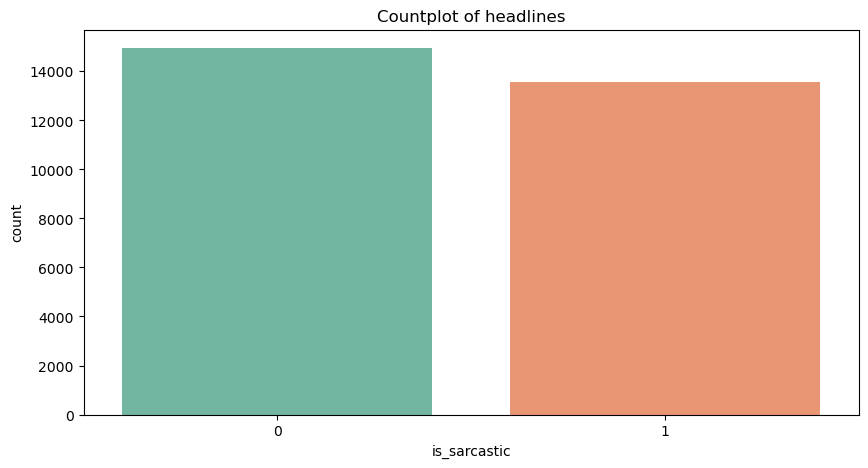

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5)) 
sns.countplot(x='is_sarcastic', data=df, palette="Set2").set_title( 
    "Countplot of headlines") 
plt.show() 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [7]:
n = df['headline'].nunique()
if n<len(df):
    print('There are duplicates')
else:
    print('No')

There are duplicates


In [8]:
df = df.drop_duplicates(subset='headline')
df.describe()

,is_sarcastic
count,28503.000000
mean,0.475459
std,0.499406
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


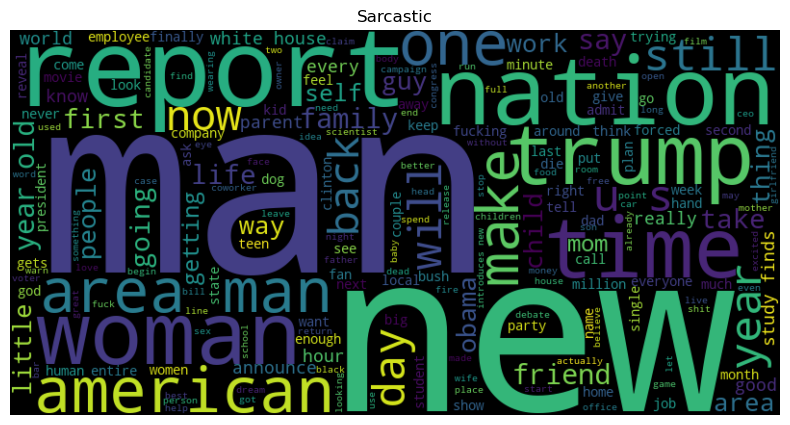

In [10]:
from wordcloud import WordCloud 
Sarcastic_text = ' '.join( 
    df['headline'][df['is_sarcastic'] == 1].tolist()) 

wordcloud = WordCloud(width=800, height=400, 
                      background_color='black').generate(Sarcastic_text) 
  
# Display the WordCloud without axes 
plt.figure(figsize=(10, 5)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Sarcastic') 
plt.show() 

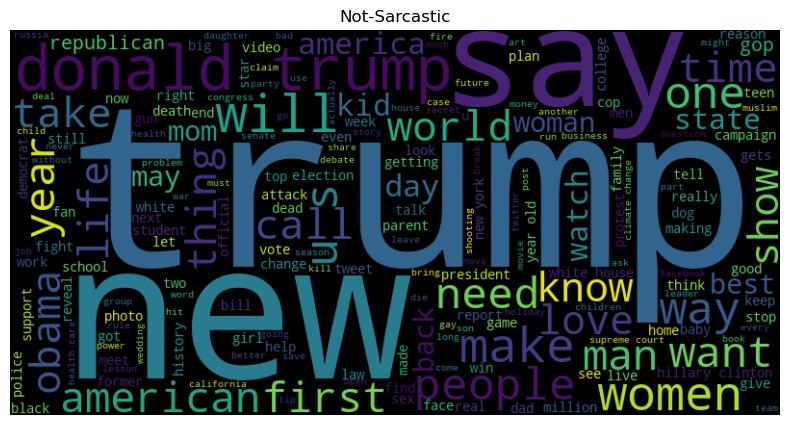

In [14]:
Sarcastic_text = ' '.join( 
    df['headline'][df['is_sarcastic'] == 0].tolist()) 

wordcloud = WordCloud(width=800, height=400, 
                      background_color='black').generate(Sarcastic_text) 
  
# Display the WordCloud without axes 
plt.figure(figsize=(10, 5)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.title('Not-Sarcastic') 
plt.show() 

In [10]:
tokenize = Tokenizer(oov_token='<oov>')  # creating keras tokenizer object
tokenize.fit_on_texts(df['headline'])  # build the vocabulary
word = tokenize.word_index  #mapping words to their respective int indices from fitted tokenizer
df['headline_sequence'] = tokenize.texts_to_sequences(df['headline']) # convert headlines into integer sequences using the word index
df['length'] = df['headline_sequence'].apply(len) # calculate the no of words in headlines

In [11]:
df = df.sort_values(by='length')
df.head()

,is_sarcastic,headline,headline_sequence,length
27120,0,explosive illusions,"[7127, 15685]",2
21220,0,another opportunity,"[208, 2264]",2
1566,1,willow rented,"[11866, 5736]",2
17383,1,ant born,"[7245, 1960]",2
17980,0,magical marseille,"[1467, 25325]",2


In [12]:
df.tail()   #outlier of 152 words

,is_sarcastic,headline,headline_sequence,length
20776,0,"'how do we treat the little people, joan?' i a...","[4544, 97, 94, 2385, 4, 159, 67, 3268, 70, 82,...",31
23598,0,occasionally you realize someone you thought w...,"[15801, 20, 1598, 510, 20, 482, 75, 7, 1510, 3...",38
24815,1,"elmore leonard, modern prose master, noted for...","[28847, 7824, 1530, 9443, 3399, 11386, 6, 31, ...",39
16588,1,"'12 years a slave,' 'captain phillips,' 'ameri...","[15162, 104, 7, 5118, 70, 6034, 24623, 70, 213...",40
7302,1,hot wheels ranked number one toy for rolling d...,"[420, 3348, 6462, 818, 43, 2634, 6, 3273, 78, ...",152


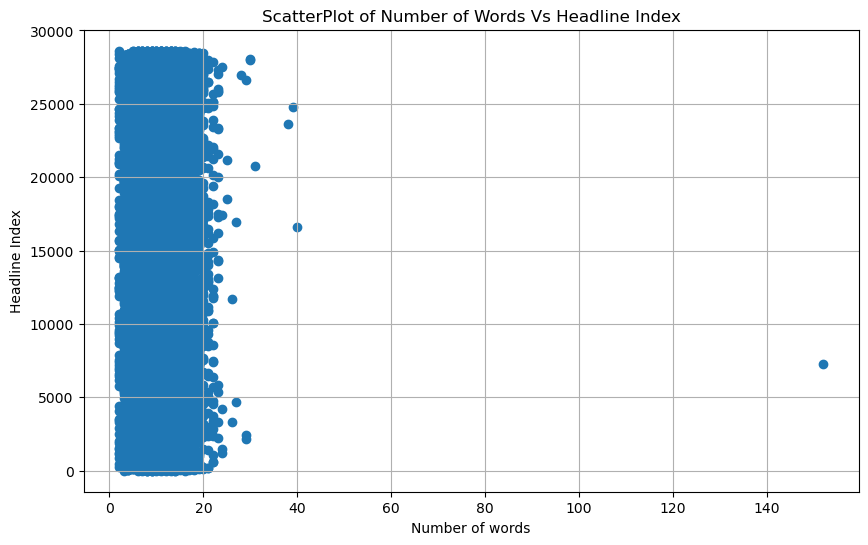

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(df['length'],df.index)
plt.title('ScatterPlot of Number of Words Vs Headline Index')
plt.xlabel('Number of words')
plt.ylabel('Headline Index')
plt.grid(True)
plt.show()

In [14]:
df_clean = df[df['length'] <=25]
print(df_clean.groupby('is_sarcastic').describe())

               length                                                 
                count       mean       std  min  25%   50%   75%   max
is_sarcastic                                                          
0             14947.0   9.967351  2.897856  2.0  8.0  10.0  12.0  25.0
1             13541.0  10.578835  3.659179  2.0  8.0  10.0  13.0  25.0


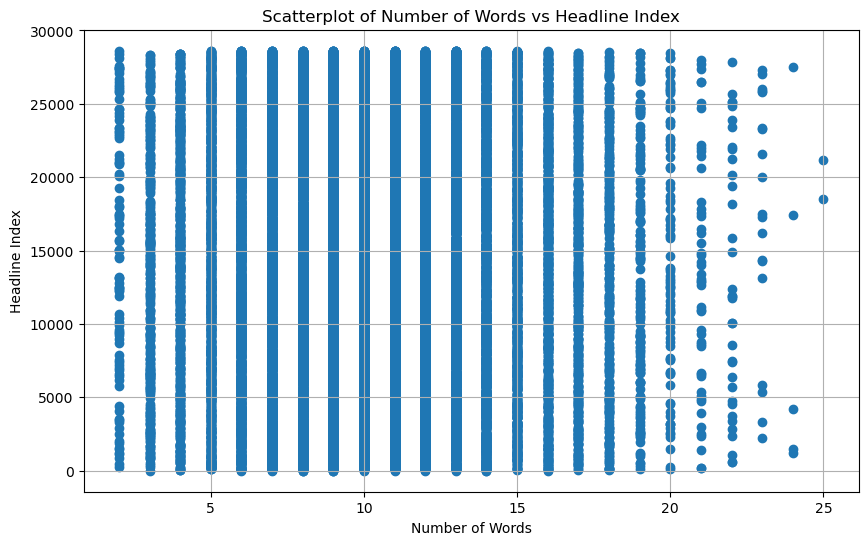

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['length'], df_clean.index)
plt.title('Scatterplot of Number of Words vs Headline Index')
plt.xlabel('Number of Words')
plt.ylabel('Headline Index')
plt.grid(True)
plt.show()

In [16]:
# splitting data into short and long headlines
df_clean['length'].median()

10.0

In [17]:
df_short = df_clean[df_clean['length'] <= df_clean['length'].median()]
df_long = df_clean[df_clean['length'] > df_clean['length'].median()]

In [18]:
print(df_short.groupby('is_sarcastic').describe() , df_long.groupby('is_sarcastic').describe())

              length                                               
               count      mean       std  min  25%  50%   75%   max
is_sarcastic                                                       
0             8386.0  7.959218  1.905585  2.0  7.0  8.0  10.0  10.0
1             7105.0  7.757635  1.830771  2.0  7.0  8.0   9.0  10.0               length                                                   
               count       mean       std   min   25%   50%   75%   max
is_sarcastic                                                           
0             6561.0  12.534065  1.657422  11.0  11.0  12.0  13.0  25.0
1             6436.0  13.693288  2.446206  11.0  12.0  13.0  15.0  25.0


In [19]:
# splitting data nto X and Y

X_long = df_long['headline']
label_long = to_categorical(df_long['is_sarcastic'],2)

X_short = df_short['headline']
label_short = to_categorical(df_short['is_sarcastic'],2)

In [20]:
df_long

,is_sarcastic,headline,headline_sequence,length
23964,0,"in 'margaritaville,' broadway's lisa howard fi...","[5, 28416, 70, 14820, 4960, 3101, 109, 2831, 9...",11
12439,0,"arcade fire, bon iver, strokes form supergroup...","[22513, 309, 7655, 22514, 10965, 1514, 14477, ...",11
10195,0,club for growth attacks donald trump with new ...,"[1300, 6, 3047, 569, 54, 13, 10, 12, 2758, 5, ...",11
7922,0,proof that human alex jones is most certainly ...,"[1963, 26, 359, 2550, 1140, 11, 99, 10494, 29,...",11
22797,1,90% of audience at college graduation involved...,"[1604, 3, 841, 15, 212, 3448, 3624, 5, 7646, 9...",11
...,...,...,...,...
1449,1,man at park who set up table full of water cup...,"[14, 15, 962, 37, 488, 22, 866, 362, 3, 426, 3...",24
17412,1,house chaplain delivers soulful prayer for god...,"[69, 8045, 1705, 10655, 4823, 6, 252, 2, 469, ...",24
4182,1,high school kicker finds it helpful to imagine...,"[158, 100, 12608, 109, 27, 6058, 2, 3491, 912,...",24
18517,1,"unearthed cave painting of wooly mammoth, sabe...","[15419, 4635, 4660, 3, 25625, 25626, 15420, 53...",25


In [21]:
Y_long = df_long['is_sarcastic']
Y_short = df_short['is_sarcastic']

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
x_long_padded = pad_sequences(df_long['headline_sequence'],padding='pre')
X_long_train , X_long_test, Y_long_train , Y_long_test = train_test_split(
    x_long_padded,
    Y_long,
    random_state= 0,
    stratify = Y_long #ensures that class distrbution is maintained in splits
)

In [24]:
x_short_padded = pad_sequences(df_short['headline_sequence'],padding='pre')
X_short_train , X_short_test, Y_short_train , Y_short_test = train_test_split(
    x_short_padded,
    Y_short,
    random_state= 0,
    stratify = Y_short #ensures that class distrbution is maintained in splits
)

In [25]:
emb = 'glove.twitter.27B.200d.txt'
def get_coe(word, *array):
    return word,np.asarray(array , dtype='float32')

with open(emb,'r',encoding='utf-8') as f:
    emb_dict = dict(get_coe(*o.rstrip().rsplit(' ')) for o in f)

In [26]:
emb_dict['sarcasm']

array([ 5.5789e-01,  1.2894e-01,  5.8807e-02, -1.7184e-01, -2.1062e-01,
        6.2724e-01,  3.8536e-01, -8.4433e-02, -1.1365e+00,  2.3821e-02,
        5.3795e-02, -6.7236e-01, -3.0422e-01,  1.1528e+00, -2.6915e-01,
        3.8259e-01, -3.9516e-01,  1.7018e-01, -1.1841e-01, -1.2170e+00,
       -2.3860e-01,  1.9965e-01,  3.4177e-01, -5.6872e-01,  3.4706e-01,
        1.4325e+00, -1.4076e-01, -5.2220e-01, -1.0320e-01, -2.6111e-01,
        3.5777e-01,  3.6756e-02, -4.0606e-01, -8.5759e-01,  2.4264e-01,
        1.2333e-02,  3.2333e-01, -5.5376e-02,  9.6043e-02,  2.3453e-01,
        1.2113e+00, -1.3714e-03,  4.8227e-01, -3.6788e-02,  6.1119e-01,
        4.1280e-01,  1.8004e-01,  1.0982e+00, -3.9601e-02, -5.0017e-01,
        6.3369e-01,  3.3001e-01,  8.4009e-03, -9.1504e-01,  8.9476e-01,
       -3.5948e-01, -6.0683e-01, -1.2135e-01, -7.2819e-01,  1.7653e-01,
       -5.3398e-01,  2.9630e-01, -1.1180e+00,  2.0071e-01,  8.2873e-02,
       -2.5766e-01, -7.1431e-01,  1.7063e-01, -1.0573e+00,  3.07

In [27]:
all_emb = np.stack(list(emb_dict.values()))
emb_mean , emb_std = all_emb.mean() ,all_emb.std()
emb_size = all_emb.shape[1]

print(emb_mean)
print(emb_std)
print(emb_size)

0.009065018
0.4428109
200


In [28]:
max_tokens = 35000 #max num of tokens to consider
unique_words = min(max_tokens,len(word)) #no of unique words
unique_words = len(word) + 1 #added 1 for out of vocabulary token

emb_matrix = np.random.normal(emb_mean,emb_std,(unique_words,emb_size))

for words,i in word.items():
    if i>=unique_words: continue
    emb_vector = emb_dict.get(words)
    
    if emb_vector is not None:
        emb_matrix[i] = emb_vector

In [29]:
print(emb_matrix[0,:])
print(emb_matrix.shape)

[ 0.49588807 -0.05199694 -0.73830475  0.01386113 -0.42449086 -0.35315702
  0.05707084  0.70571082  0.8150023  -0.39492272 -0.38815336 -0.24048575
 -0.41371095  0.58970976  0.1432532   0.31484752  0.94094126 -0.1911899
  0.52925368  0.25829679 -0.16117586  0.14603262 -0.1398937   0.42140206
  0.69706868  0.13890796  0.51088082  0.2413055   0.13011621 -0.60717909
 -0.18189059 -0.37701733 -0.42754827  0.88785637  0.07458284 -0.22988046
  0.60417274  0.43624461  0.09080934 -0.32977503 -0.7851404   0.29635419
  0.36066459  0.21592991  0.16705673  0.1263343  -0.42811909 -0.6920514
  0.4727834  -0.19161563  0.62138392 -0.48514449  0.22976083 -0.33796569
  0.4161496   0.01982575  0.40884738  0.76817428 -0.37013939  0.55710964
 -0.18544501  0.08015592 -0.81525998  0.13698194  0.01758545  0.00179475
 -0.59343033  0.33748344  0.04837438 -0.11796327  0.63044934 -0.14455034
  0.46001063  0.65039753  0.00727516 -0.21061649 -0.40122988 -0.03396604
 -0.21411858 -0.6327346   0.32289391  0.16161183  0.2

In [30]:
# Building Models
random.seed(2023)
model_long = Sequential()
model_long.add(Embedding(input_dim = unique_words,
                               output_dim = emb_size,
                               weights = [emb_matrix],
                               input_length = 25,
                               trainable = True))
model_long.add(Bidirectional(LSTM(units=128,recurrent_dropout=0.5,dropout=0.5)))
model_long.add(Dense(1,activation='sigmoid')) #binary classification

model_long.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['acc'])


In [31]:
random.seed(2023)
model_short = Sequential()
model_short.add(Embedding(input_dim = unique_words, 
                    output_dim = emb_size, 
                    weights = [emb_matrix], 
                    input_length = 10, # each sentence was padded to the length of 10 tokens
                    trainable = True))
model_short.add(Bidirectional(LSTM(units = 128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model_short.add(Dense(1, activation = 'sigmoid')) # binary classification

model_short.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['acc'])

In [32]:
# Train long headlines dataset
history_long = model_long.fit(
    X_long_train,
    Y_long_train,
    batch_size = 128,
    validation_data = (X_long_test, Y_long_test),
    epochs = 2
)

Epoch 1/2


77/77 [==============================] - 43s 462ms/step - loss: 0.5244 - acc: 0.7435 - val_loss: 0.3016 - val_acc: 0.8668
Epoch 2/2
77/77 [==============================] - 34s 446ms/step - loss: 0.1781 - acc: 0.9312 - val_loss: 0.3271 - val_acc: 0.8794


In [33]:
# Train short headlines dataset
history_short = model_short.fit(
    X_short_train,
    Y_short_train,
    batch_size = 128,
    validation_data = (X_short_test, Y_short_test),
    epochs=2)

Epoch 1/2
91/91 [==============================] - 24s 182ms/step - loss: 0.4225 - acc: 0.7993 - val_loss: 0.3346 - val_acc: 0.8518
Epoch 2/2
91/91 [==============================] - 15s 166ms/step - loss: 0.1420 - acc: 0.9473 - val_loss: 0.4435 - val_acc: 0.8386


In [34]:
lstm_short_val_acc = round(history_short.history['val_acc'][-1]*100, 2)
lstm_long_val_acc = round(history_long.history['val_acc'][-1]*100, 2)

# Print the final validation accuracies
print(lstm_short_val_acc, lstm_long_val_acc)

83.86 87.94


## BERT BASE

In [48]:

X_long = df_long['headline']
Y_long = df_long['is_sarcastic']
X_short = df_short['headline']
Y_short = df_short['is_sarcastic']

X_long_train, X_long_test,Y_long_train,Y_long_test = train_test_split(X_long,Y_long,test_size=0.2)
X_short_train,X_short_test,Y_short_train,Y_short_test = train_test_split(X_short,Y_short,test_size=0.2)

In [49]:
#Labelencoder to convert labels to integers
label_encoder = LabelEncoder()
Y_long_train_encod = label_encoder.fit_transform(Y_long_train)
Y_long_test_encod = label_encoder.transform(Y_long_test)
Y_short_train_encod = label_encoder.fit_transform(Y_short_train)
Y_short_test_encod = label_encoder.transform(Y_short_test)

In [57]:
!pip install --upgrade transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/a4/73/f620d76193954e16db3d5c53a07d956d7b9c800e570758d3bff91906d4a4/transformers-4.39.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/134.8 kB ? eta -:--:--
     -------------------------------------- 134.8/134.8 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for safetensors>=0.4.1 from https://files.pythonhosted.org/packages/54/ce/09e508c682c612e7ff7b5cf1249a963d10db58f16d77007177f7770c661b/safetensors-0.4.2-cp311-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
    --------------------------------------- 0.2/8.8 MB 5.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/8.8 MB 6.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.8 MB 8.0 MB/s eta 0:00:01
   -------- ------------------------------- 1.9/8.8 MB 10.1 MB/s eta 0:00:01
   ------------ -------------------------

In [50]:
#BERT tokenization
pretrained = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained,do_lower_case=True)

def encoder(sentences):
    ids=[]
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
        sentence,
        max_length=16,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length = True,
        return_attention_mask=False)
        ids.append(encoding['input_ids'])
    return ids

#tokenization
x_long_train_ids = encoder(X_long_train)
x_long_test_ids = encoder(X_long_test)
x_short_train_ids = encoder(X_short_train)
x_short_test_ids = encoder(X_short_test)

#Data transformation
#converting arrays to tensors for long
x_long_train_ids = tf.convert_to_tensor(x_long_train_ids)
x_long_test_ids = tf.convert_to_tensor(x_long_test_ids)
Y_long_test = tf.convert_to_tensor(Y_long_test_encod)
Y_long_train = tf.convert_to_tensor(Y_long_train_encod)

#for short headline
x_short_train_ids = tf.convert_to_tensor(x_short_train_ids)
x_short_test_ids = tf.convert_to_tensor(x_short_test_ids)
Y_short_test = tf.convert_to_tensor(Y_short_test_encod)
Y_short_train = tf.convert_to_tensor(Y_short_train_encod)

C:\Users\yashika\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
# long sentences Bert Model (version 12 layer, 768 hidden, 12 heads)
bert_encod = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,),dtype=tf.int32,name='input_word_ids')
emb = bert_encod([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:,0,:])(emb[0])
dense = tf.keras.layers.Dense(128,activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
op = tf.keras.layers.Dense(1,activation='sigmoid')(dense)
model = tf.keras.Model(inputs =[input_word_ids],outputs=op)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [56]:
bert_encod.trainable = False

In [57]:
model.compile(tf.keras.optimizers.legacy.Adam(1e-5),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 16)]              0         
 )                                                               
                                                                 
 tf_bert_model_3 (TFBertMod  TFBaseModelOutputWithPo   109482240 
 el)                         olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 16, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                 

In [58]:
# long sent model

long_model = model.fit(x=x_long_train_ids,y=Y_long_train,epochs=5,verbose=1,batch_size=32,validation_data=(x_long_test_ids,Y_long_test))

Epoch 1/5
325/325 [==============================] - 575s 2s/step - loss: 0.6915 - accuracy: 0.5550 - val_loss: 0.6270 - val_accuracy: 0.6862
Epoch 2/5
325/325 [==============================] - 548s 2s/step - loss: 0.6290 - accuracy: 0.6477 - val_loss: 0.5801 - val_accuracy: 0.7358
Epoch 3/5
325/325 [==============================] - 530s 2s/step - loss: 0.5960 - accuracy: 0.6935 - val_loss: 0.5491 - val_accuracy: 0.7665
Epoch 4/5
325/325 [==============================] - 529s 2s/step - loss: 0.5686 - accuracy: 0.7198 - val_loss: 0.5269 - val_accuracy: 0.7696
Epoch 5/5
325/325 [==============================] - 514s 2s/step - loss: 0.5526 - accuracy: 0.7315 - val_loss: 0.5107 - val_accuracy: 0.7823


In [59]:
# short sentences Bert Model
bert_encod = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,),dtype=tf.int32,name='input_word_ids')
emb = bert_encod([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:,0,:])(emb[0])
dense = tf.keras.layers.Dense(128,activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
op = tf.keras.layers.Dense(1,activation='sigmoid')(dense)
model = tf.keras.Model(inputs =[input_word_ids],outputs=op)
bert_encod.trainable = False
model.compile(tf.keras.optimizers.legacy.Adam(0.01),loss='binary_crossentropy',metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [60]:
short_model = model.fit(x = x_short_train_ids, y = Y_short_train, epochs = 5, verbose = 1, batch_size = 32, validation_data = (x_short_test_ids, Y_short_test))

Epoch 1/5
388/388 [==============================] - 614s 2s/step - loss: 0.4837 - accuracy: 0.7730 - val_loss: 0.4109 - val_accuracy: 0.8096
Epoch 2/5
388/388 [==============================] - 587s 2s/step - loss: 0.4242 - accuracy: 0.8048 - val_loss: 0.5036 - val_accuracy: 0.7777
Epoch 3/5
388/388 [==============================] - 585s 2s/step - loss: 0.4177 - accuracy: 0.8063 - val_loss: 0.3876 - val_accuracy: 0.8312
Epoch 4/5
388/388 [==============================] - 574s 1s/step - loss: 0.4074 - accuracy: 0.8138 - val_loss: 0.3700 - val_accuracy: 0.8254
Epoch 5/5
388/388 [==============================] - 572s 1s/step - loss: 0.3956 - accuracy: 0.8208 - val_loss: 0.3541 - val_accuracy: 0.8477


In [61]:
# Accessing training and validation accuracy and loss values for the long model
long_train_accuracy = long_model.history['accuracy']
long_val_accuracy = long_model.history['val_accuracy']
long_train_loss = long_model.history['loss']
long_val_loss = long_model.history['val_loss']

# Accessing training and validation accuracy and loss values for the short model
short_train_accuracy = short_model.history['accuracy']
short_val_accuracy = short_model.history['val_accuracy']
short_train_loss = short_model.history['loss']
short_val_loss = short_model.history['val_loss']

In [62]:
y_short_pred = model.predict(x_short_test_ids)
y_short_pred_classes = (y_short_pred > 0.5).astype('int')  # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix for the short model
conf_matrix_short = confusion_matrix(Y_short_test, y_short_pred_classes)

# Print confusion matrix for the short model
print("Confusion Matrix:")
print(conf_matrix_short)

# Calculate and print classification report for the short model
class_report_short = classification_report(Y_short_test, y_short_pred_classes)
print("\nClassification Report:")
print(class_report_short)

97/97 [==============================] - 110s 1s/step
Confusion Matrix:
[[1383  322]
 [ 150 1244]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1705
           1       0.79      0.89      0.84      1394

    accuracy                           0.85      3099
   macro avg       0.85      0.85      0.85      3099
weighted avg       0.85      0.85      0.85      3099



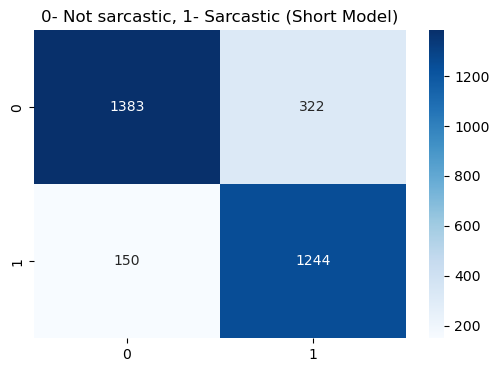

In [63]:
# Plot confusion matrix for the short model
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_short, annot=True, fmt='d', cmap='Blues')
plt.title("0- Not sarcastic, 1- Sarcastic (Short Model)")
plt.show()

In [64]:
y_long_pred = model.predict(x_long_test_ids)
y_long_pred_classes = (y_long_pred > 0.5).astype('int')  # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix_long = confusion_matrix(Y_long_test, y_long_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_long)

# Calculate and print classification report
class_report = classification_report(Y_long_test, y_long_pred_classes)
print("\nClassification Report:")
print(class_report)

82/82 [==============================] - 88s 1s/step
Confusion Matrix:
[[1159  175]
 [ 244 1022]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1334
           1       0.85      0.81      0.83      1266

    accuracy                           0.84      2600
   macro avg       0.84      0.84      0.84      2600
weighted avg       0.84      0.84      0.84      2600



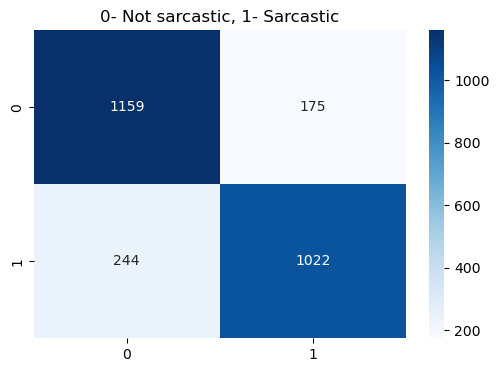

In [65]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_long,annot=True,fmt='d',cmap='Blues')
plt.title("0- Not sarcastic, 1- Sarcastic")
plt.show()

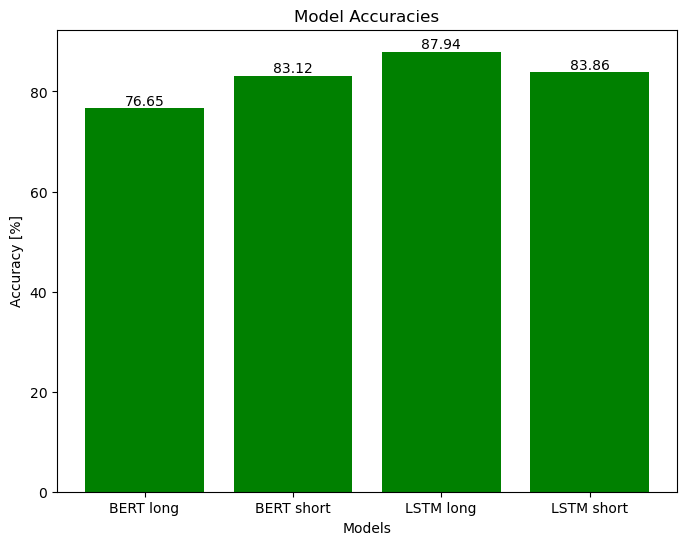

In [66]:
import matplotlib.pyplot as plt

# Sample accuracy values for four models
accuracies = [long_val_accuracy[2] * 100, short_val_accuracy[2] * 100, lstm_long_val_acc, lstm_short_val_acc]  # Replace these with your actual accuracy values

# Labels for each model
labels = ['BERT long', 'BERT short', 'LSTM long', 'LSTM short']

# Create a bar chart
plt.figure(figsize=(8, 6))  # Set the size of the plot
bars = plt.bar(labels, accuracies, color='green')  # Plot bars with labels and accuracy values

# Adding data labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding title and labels
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy [%]')

# Display the plot
plt.show()

In [67]:
long_train_accuracy = long_model.history['accuracy']
long_val_accuracy = long_model.history['val_accuracy']
long_train_loss = long_model.history['loss']
long_val_loss = long_model.history['val_loss']

# Accessing training and validation accuracy and loss values for the short model
short_train_accuracy = short_model.history['accuracy']
short_val_accuracy = short_model.history['val_accuracy']
short_train_loss = short_model.history['loss']
short_val_loss = short_model.history['val_loss']

# Print summaries
print("\nShort Model Summary:")
print("Training Accuracy:", short_train_accuracy[-1])
print("Validation Accuracy:", short_val_accuracy[-1])
print("Training Loss:", short_train_loss[-1])
print("Validation Loss:", short_val_loss[-1])

print("\nLong Model Summary:")
print("Training Accuracy:", long_train_accuracy[-1])
print("Validation Accuracy:", long_val_accuracy[-1])
print("Training Loss:", long_train_loss[-1])
print("Validation Loss:", long_val_loss[-1])


Short Model Summary:
Training Accuracy: 0.8207714557647705
Validation Accuracy: 0.8476927876472473
Training Loss: 0.3956427574157715
Validation Loss: 0.3541415333747864

Long Model Summary:
Training Accuracy: 0.7314609885215759
Validation Accuracy: 0.7823076844215393
Training Loss: 0.55255526304245
Validation Loss: 0.510668158531189


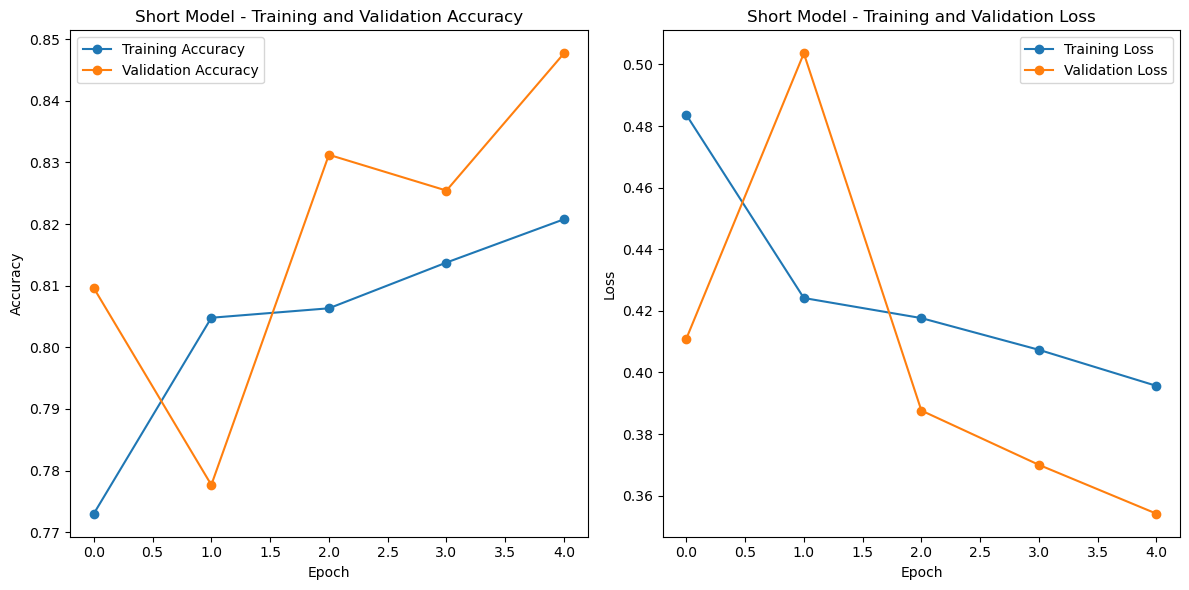

In [68]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(short_train_accuracy, label='Training Accuracy', marker='o')
plt.plot(short_val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Short Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(short_train_loss, label='Training Loss', marker='o')
plt.plot(short_val_loss, label='Validation Loss', marker='o')
plt.title('Short Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

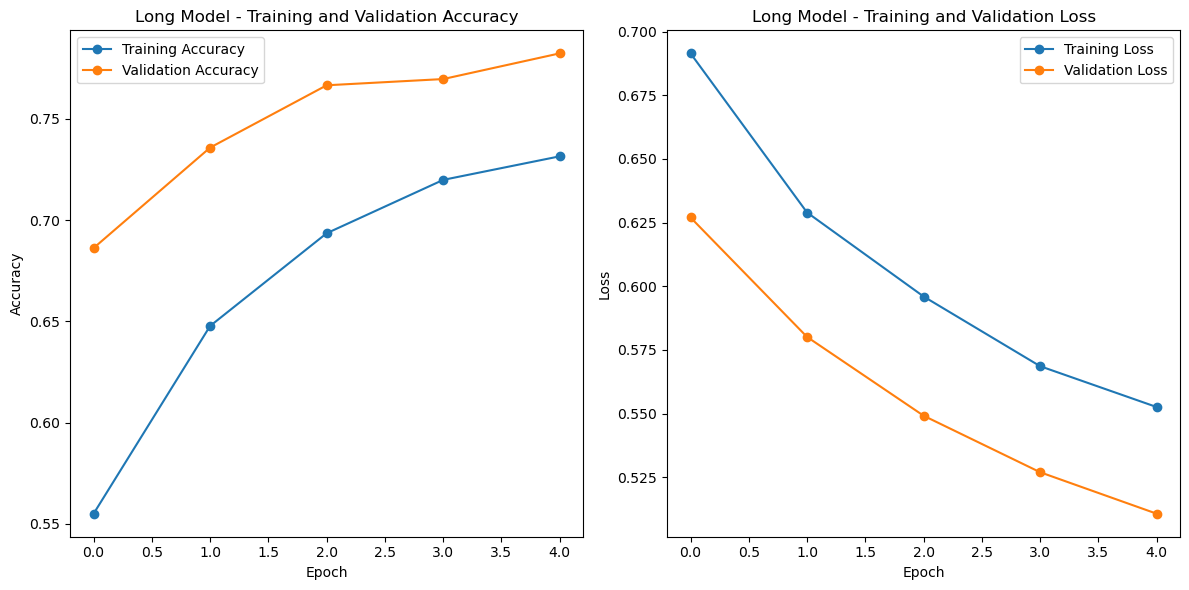

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(long_model.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(long_model.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Long Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(long_model.history['loss'], label='Training Loss', marker='o')
plt.plot(long_model.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Long Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
# Define threshold for binary classification (adjust as needed)
threshold = 0.5

# Define max_length_lstm according to your LSTM model's input requirements
max_length_lstm = 25

# Tokenize headlines for LSTM
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(X_long_train)  # Assuming X_long_train contains your long headlines
def preprocess_headline_lstm(headline):
    # Tokenize the headline using the LSTM tokenizer
    tokenized_headline = tokenizer_lstm.texts_to_sequences([headline])
    # Pad sequences to ensure consistent length based on model_short's input length
    padded_headline = pad_sequences(tokenized_headline, maxlen=10, padding='post')
    return padded_headline

def predict_sarcasm_lstm(model, headline):
    # Preprocess the headline for LSTM model
    input_ids = preprocess_headline_lstm(headline)
    # Make predictions using the LSTM model
    predictions = model.predict(input_ids)
    # Determine if the headline is sarcastic or not based on the threshold
    sarcasm_label = "Sarcastic" if predictions > threshold else "Not Sarcastic"
    return sarcasm_label


In [77]:
new_long_headline = "I just love it when my alarm clock wakes me up from my deep, peaceful slumber. It's truly the highlight of my day."
new_short_headline = "Unbelievable! Scientists discover water on Mars"

# Predict sarcasm for long headline
long_lstm_prediction = predict_sarcasm_lstm(model_long, new_long_headline)

# Predict sarcasm for short headline
short_lstm_prediction = predict_sarcasm_lstm(model_short, new_short_headline)

# Print predictions
print("Long Headline Prediction (LSTM):", long_lstm_prediction)
print("Short Headline Prediction (LSTM):", short_lstm_prediction)

1/1 [==============================] - 0s 53ms/step
Long Headline Prediction (LSTM): Sarcastic
Short Headline Prediction (LSTM): Sarcastic


In [80]:
new_long_headline = "Scientists Finally Conclude Earth Is Neither Flat Nor Hollow"
new_short_headline = "Stock Market Reaches All-Time High"

# Predict sarcasm for long headline
long_lstm_prediction = predict_sarcasm_lstm(model_long, new_long_headline)

# Predict sarcasm for short headline
short_lstm_prediction = predict_sarcasm_lstm(model_short, new_short_headline)

# Print predictions
print("Long Headline Prediction (LSTM):", long_lstm_prediction)
print("Short Headline Prediction (LSTM):", short_lstm_prediction)

1/1 [==============================] - 0s 62ms/step
Long Headline Prediction (LSTM): Sarcastic
Short Headline Prediction (LSTM): Sarcastic


In [81]:
new_long_headline = "Scientists Discover New Way to Lose Weight: Stop Eating!"
new_short_headline = "Tech company launches innovative product"

# Predict sarcasm for long headline
long_lstm_prediction = predict_sarcasm_lstm(model_long, new_long_headline)

# Predict sarcasm for short headline
short_lstm_prediction = predict_sarcasm_lstm(model_short, new_short_headline)

# Print predictions
print("Long Headline Prediction (LSTM):", long_lstm_prediction)
print("Short Headline Prediction (LSTM):", short_lstm_prediction)

1/1 [==============================] - 0s 45ms/step
Long Headline Prediction (LSTM): Sarcastic
Short Headline Prediction (LSTM): Not Sarcastic
